In [88]:
import pandas as pd
from urllib.parse import unquote
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
# Define a tuple of file paths and column names
files_and_columns = (
    ('../data/paths_finished.tsv', ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating']),
    ('../data/paths_unfinished.tsv', ['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type']),
    ('../data/articles.tsv', ['article']),
    ('../data/categories.tsv', ['article', 'category'])
)

def read_files(file_tuples):
    dataframes = []
    for path, column_names in file_tuples:
        df = pd.read_csv(path, sep='\t', comment='#', names=column_names, header=None)
        dataframes.append(df)
    return dataframes

paths_finished, paths_unfinished, articles, categories  = read_files(files_and_columns)

articles.head()



,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


In [90]:
categories.head() 

,article,category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.History.British_History.British_Histor...
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,subject.People.Historical_figures
2,%C3%85land,subject.Countries
3,%C3%85land,subject.Geography.European_Geography.European_...
4,%C3%89douard_Manet,subject.People.Artists


In [91]:
from urllib.parse import unquote

# Decode the article names
articles['article'] = articles['article'].apply(lambda x: unquote(x))
categories['article'] = categories['article'].apply(lambda x: unquote(x))

categories


,article,category
0,Áedán_mac_Gabráin,subject.History.British_History.British_Histor...
1,Áedán_mac_Gabráin,subject.People.Historical_figures
2,Åland,subject.Countries
3,Åland,subject.Geography.European_Geography.European_...
4,Édouard_Manet,subject.People.Artists
...,...,...
5199,Zirconium,subject.Science.Chemistry.Chemical_elements
5200,Zoroaster,subject.People.Religious_figures_and_leaders
5201,Zuid-Gelders,subject.Geography.European_Geography
5202,Zuid-Gelders,subject.Language_and_literature.Languages


In [92]:
# Remove 'subject.' prefix and split each category string by '.'
categories_split = categories['category'].str.replace('^subject\.', '', regex=True).str.split('.')

# Create new columns based on the number of subcategories
max_depth = categories_split.apply(len).max()
for i in range(max_depth):
    categories[f'subcategory_{i + 1}'] = categories_split.apply(lambda x: x[i] if i < len(x) else None)

categories.drop(columns=['category'])

,article,subcategory_1,subcategory_2,subcategory_3
0,Áedán_mac_Gabráin,History,British_History,British_History_1500_and_before_including_Roma...
1,Áedán_mac_Gabráin,People,Historical_figures,None
2,Åland,Countries,None,None
3,Åland,Geography,European_Geography,European_Countries
4,Édouard_Manet,People,Artists,None
...,...,...,...,...
5199,Zirconium,Science,Chemistry,Chemical_elements
5200,Zoroaster,People,Religious_figures_and_leaders,None
5201,Zuid-Gelders,Geography,European_Geography,None
5202,Zuid-Gelders,Language_and_literature,Languages,None


In [93]:
articles_shape = articles.shape
categories_shape = categories.shape

unique_articles = articles['article'].nunique()
unique_categories = categories['article'].nunique()

article_counts = articles['article'].value_counts()
category_counts = categories['article'].value_counts()

articles_repetitions = (article_counts[article_counts > 1].sum())
categories_repetitions = (category_counts[category_counts > 1].sum())
categories_2repetitions = (category_counts[category_counts > 2].sum())
categories_3repetitions = (category_counts[category_counts > 3].sum())

print(f"Articles shape: {articles_shape}")
print(f"Categories shape: {categories_shape}")
print(f"Unique articles: {unique_articles}")
print(f"Unique categories articles: {unique_categories}")
print(f"Repetitions in articles: {articles_repetitions}")
print(f"Repetitions in categories articles: {categories_repetitions}")
print(f"2 Repetitions in categories articles: {categories_2repetitions}")
print(f"3 Repetitions in categories articles: {categories_3repetitions}")


Articles shape: (4604, 1)
Categories shape: (5204, 5)
Unique articles: 4604
Unique categories articles: 4598
Repetitions in articles: 0
Repetitions in categories articles: 1204
2 Repetitions in categories articles: 24
3 Repetitions in categories articles: 0


In [94]:
not_in_articles = categories[~categories['article'].isin(articles['article'])]

print("Categories not found in articles:", not_in_articles)

dont_have_category = articles[~articles['article'].isin(categories['article'])]

dont_have_category

Categories not found in articles: Empty DataFrame
Columns: [article, category, subcategory_1, subcategory_2, subcategory_3]
Index: []


,article
1210,Directdebit
1231,Donation
1600,Friend_Directdebit
3253,Pikachu
3849,Sponsorship_Directdebit
4545,Wowpurchase


In [95]:
paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [114]:
path_split = paths_finished['path'].str.split(';')
paths_finished['num_links'] = path_split.str.len()

link_columns = {}

max_length = paths_finished['num_links'].max()
for i in range(max_length):
    link_columns[f'link_{i + 1}'] = path_split.apply(lambda x: x[i] if i < len(x) else None)

links_df = pd.DataFrame(link_columns)

paths_finished = pd.concat([paths_finished, links_df], axis=1)
# paths_finished.drop(columns=['path'], inplace=True)
paths_finished


,hashedIpAddress,timestamp,durationInSec,path,rating,num_links,link_1,link_2,link_3,link_4,...,link_426,link_427,link_428,link_429,link_430,link_431,link_432,link_433,link_434,link_435
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,9,14th_century,15th_century,16th_century,Pacific_Ocean,...,None,None,None,None,None,None,None,None,None,None
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,5,14th_century,Europe,Africa,Atlantic_slave_trade,...,None,None,None,None,None,None,None,None,None,None
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,8,14th_century,Niger,Nigeria,British_Empire,...,None,None,None,None,None,None,None,None,None,None
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,4,14th_century,Renaissance,Ancient_Greece,Greece,...,None,None,None,None,None,None,None,None,None,None
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,7,14th_century,Italy,Roman_Catholic_Church,HIV,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51313,15a13a1d66ef5456,1349231015,66,Yagan;Ancient_Egypt;Civilization,NaN,3,Yagan,Ancient_Egypt,Civilization,None,...,None,None,None,None,None,None,None,None,None,None
51314,2ef7ac844cefda58,1300254138,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0,9,Yagan,Folklore,Brothers_Grimm,<,...,None,None,None,None,None,None,None,None,None,None
51315,12863abb7887f890,1385095372,228,Yagan;Australia;England;France;United_States;T...,NaN,7,Yagan,Australia,England,France,...,None,None,None,None,None,None,None,None,None,None
51316,19f8284371753362,1298792567,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0,4,Yarralumla%2C_Australian_Capital_Territory,Australia,United_States,Abraham_Lincoln,...,None,None,None,None,None,None,None,None,None,None


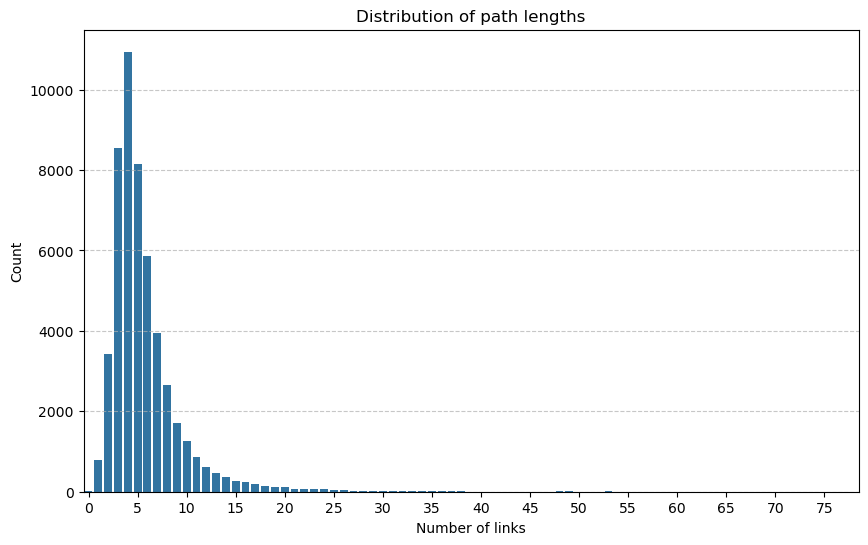

,path,num_links
8046,United_States;Washington%2C_D.C.;Government;Co...,435
19961,Napoleon_I_of_France;United_Kingdom;Great_Brit...,119
6945,Police_state;Police;United_States;Washington%2...,104
27136,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,99
22845,Britney_Spears;Las_Vegas%2C_Nevada;<;Las_Vegas...,96
...,...,...
23347,Apple,1
50466,William_and_Mary,1
33832,Abel_Tasman,1
9872,Coal,1


In [105]:
paths_finished['num_links'] = path_split.str.len()

max_length = paths_finished['num_links'].max()

plt.figure(figsize=(10, 6))
sns.countplot(x='num_links', data=paths_finished)
plt.title('Distribution of path lengths')
plt.xlabel('Number of links')
plt.ylabel('Count')
current_ticks = plt.xticks()[0]
plt.xticks(ticks=current_ticks, labels=current_ticks)
plt.xticks([tick for tick in current_ticks if tick % 5 == 0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

sorted_path = paths_finished.sort_values(by='num_links', ascending=False)
sorted_path[['path', 'num_links']]

In [ ]:
#what should we do when someone goes back? sign <

Number of rows with valid ratings: 28501
Percentage of rows with valid ratings: 55.54%


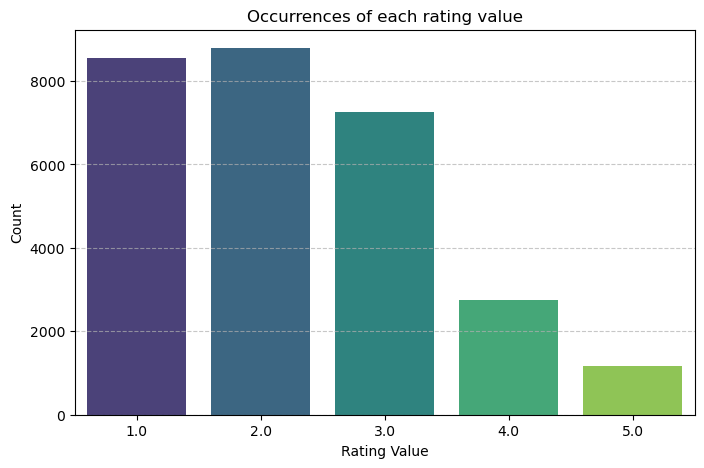

In [125]:
ratings_count = paths_finished['rating'].notna().sum()

total_rows = len(paths_finished)

percentage_valid_ratings = (ratings_count / total_rows) * 100

print(f'Number of rows with valid ratings: {ratings_count}')
print(f'Percentage of rows with valid ratings: {percentage_valid_ratings:.2f}%')

rating_counts = paths_finished['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    x=rating_counts.index.astype(str), 
    y=rating_counts.values, 
    hue=rating_counts.index.astype(str),  
    palette='viridis', 
    dodge=False, 
    legend=False
)
plt.title('Occurrences of each rating value')
plt.xlabel('Rating Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [134]:
ip_count = paths_finished['hashedIpAddress'].value_counts()
ip_count_sorted = ip_count.sort_values(ascending=False)

ip_count_sorted 


hashedIpAddress
0d57c8c57d75e2f5    4865
473d6ac602c2b198     545
7d5624e35c9523ef     292
5bb5836b425e6bfe     243
6b039e9953cf075e     231
                    ... 
431723442d2a136f       1
2da5c64073ffbe4f       1
4bd258066a3e40e5       1
61c264506547bc9c       1
052ba30a41ff5a05       1
Name: count, Length: 14244, dtype: int64

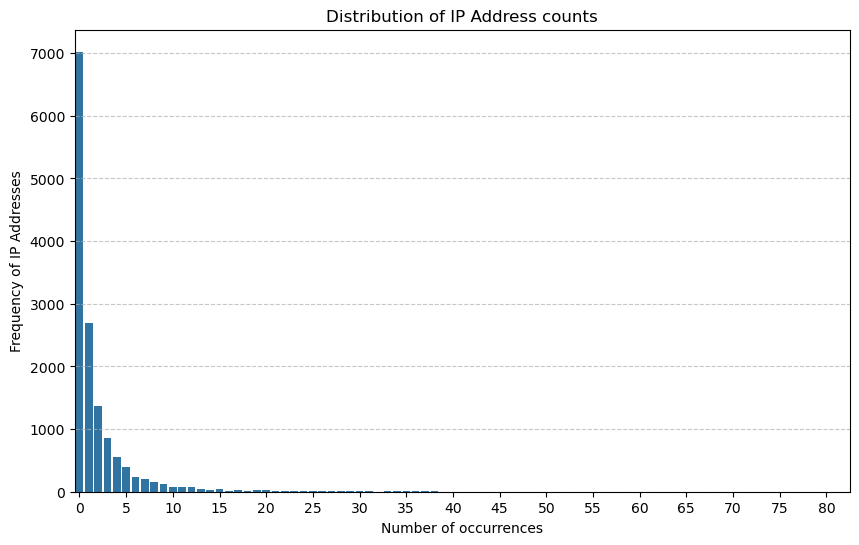

count
1       7022
2       2696
3       1366
4        864
5        547
        ... 
231        1
243        1
292        1
545        1
4865       1
Name: count, Length: 83, dtype: int64

In [136]:
count_distribution = ip_count_sorted.value_counts().sort_index()

# Plot the distribution of counts
plt.figure(figsize=(10, 6))
sns.barplot(x=count_distribution.index, y=count_distribution.values)

plt.title('Distribution of IP Address counts')
plt.xlabel('Number of occurrences')
plt.ylabel('Frequency of IP Addresses')
current_ticks = plt.xticks()[0]
plt.xticks(ticks=current_ticks, labels=current_ticks)
plt.xticks([tick for tick in current_ticks if tick % 5 == 0])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

count_distribution

In [115]:
paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout
